In [1]:
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, dataset
from torchvision.datasets import ImageFolder
import torchvision.models as models
from PIL import Image

In [2]:
data_route = '/content/drive/MyDrive/Korea it 아카데미/ComputerVision/data/1'

In [3]:
def display_images(image_paths, title, max_images = 4) :
    plt.figure(figsize = (12, 3))

    for i, image_path in enumerate(image_paths[: max_images]) :
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.show()


In [4]:
categories = ['Train Clean', 'Train Messy',
              'Val Clean', 'Val Messy',
              'Test Clean', 'Test Messy']


In [5]:
for category in categories :
    image_paths = glob.glob(f'{data_route}/{category.lower().replace(" ", "/")}/*')
    # print(image_paths)
    display_images(image_paths, category)
    print(f'{category} 총 이미지 수 : {len(image_paths)}')

Output hidden; open in https://colab.research.google.com to view.

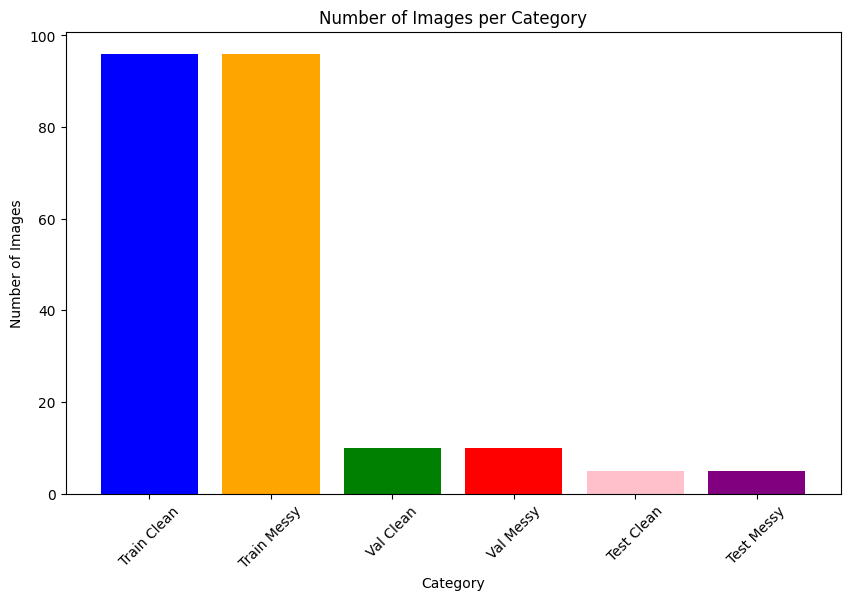

In [6]:
plt.figure(figsize = (10, 6))
plt.bar(categories, [len(glob.glob(f'{data_route}/{category.lower().replace(" ", "/")}/*'))
    for category in categories], color = ['blue', 'orange', 'green', 'red', 'pink', 'purple'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation = 45)

plt.show()

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
train_dataset = ImageFolder(f'{data_route}/train', transform = transform)
val_dataset = ImageFolder(f'{data_route}/val', transform = transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle = False)

### Alexnet

* 2012년 이미지 인식 경진대회(ILSVRC,ImageNet Large Scale Visual Reconition Challenge) 에서 큰 성과를 거두며 컴퓨터 비전 분야에 혁신을 가져온 CNN 모델
* 224 * 224 * 3 크기의 컬러 이미지를 입력
* 이미지에서 특징을 추출하는 역활인 5개의 컨벌루션 레이어를 사용
* Max-Pooling 레이어를 통해 공간 크기를 줄이면서 가장 중요한 정보를 유지
* ReLu 함수를 활성화 함수로 사용하여 학습 속도를 크게 향상
* 드롭아웃 기법을 사용하여 오비 피팅을 방지
* 마지막 두 레이어는 4096개의 파라미터를 가지고 있으며 마지막 레이어는 1000개의 클래스로 분류

<img src='https://cdn.datamaker.io/datamaker-erp/media/uploads/2020/09/16/deepnetvis_small.png'>

In [10]:
model = models.alexnet(pretrained = True)

model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
for param in model.parameters() :
    param.requires_grad = False

In [12]:
model.classifier[6] = nn.Linear(4096, 2)

model.classifier[5].requires_grad_ = True
model.classifier[6].requires_grad_ = True

In [13]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [14]:
def calculate_accuracy(loader, model) :
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad() :

        for data in loader :
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [15]:
train_losses = []
val_losses = []
val_accuracies = []

In [16]:
epochs = 5

for epoch in range(epochs) :
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader) :
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0.0
    model.eval()

    with torch.no_grad() :

        for inputs, labels in val_loader :
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = calculate_accuracy(val_loader, model)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Train Loss : {train_loss : .6f}, Val Loss : {val_loss : .6f}, Val Accuracy : {val_accuracy : .2f}%')

Epoch 1, Train Loss :  0.646250, Val Loss :  0.413908, Val Accuracy :  95.00%
Epoch 2, Train Loss :  0.351940, Val Loss :  0.269453, Val Accuracy :  95.00%
Epoch 3, Train Loss :  0.247232, Val Loss :  0.201498, Val Accuracy :  100.00%
Epoch 4, Train Loss :  0.211335, Val Loss :  0.167900, Val Accuracy :  100.00%
Epoch 5, Train Loss :  0.177523, Val Loss :  0.138924, Val Accuracy :  100.00%


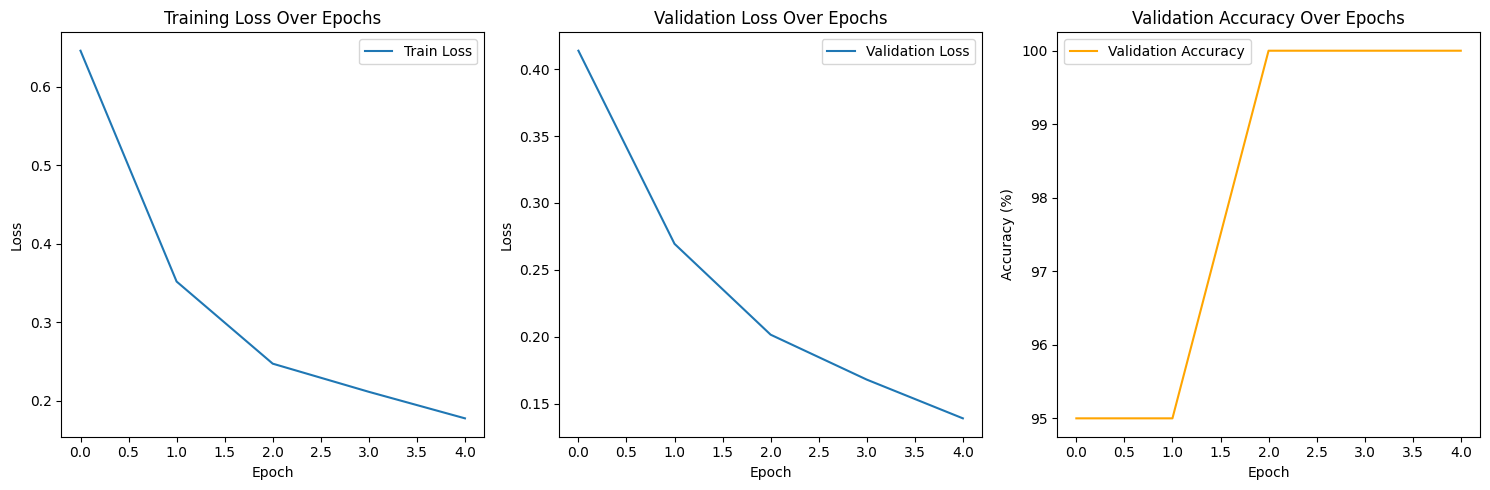

In [17]:
plt.figure(figsize=(15, 5))

# 학습 손실 그래프

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프

plt.subplot(1, 3, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
def load_and_transform_image(image_path, transform) :
    image = Image.open(image_path).convert('RGB')

    return transform(image).unsqueeze(0)

In [24]:
class_folders = {
    'clean' : f'{data_route}/test/clean',
    'messy' : f'{data_route}/test/messy'
}

In [27]:
plt.figure(figsize = (20, 8))
counter = 1

for class_name, folder_path in class_folders.items() :
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[: 5]

    for image_path in selected_paths :
        image = load_and_transform_image(image_path, transform)

        model.eval()

        with torch.no_grad() :
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

        prediction = 'clean' if predicted.item() == 0 else 'messy'

        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True : {class_name}, Pred : {prediction}')
        plt.axis('off')
        counter += 1

plt.tight_layout()
plt.show()